In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import torch
import lightning as L
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger

sys.path.append('../source')

from utils import *
from data import *

**Import Data**

In [ ]:
data_root = '../../data/set01/'

In [ ]:
dataset = LSTDataset(
    os.path.join(data_root, 'ground_truth'), 
    os.path.join(data_root, 'masked_images'),
    os.path.join(data_root, 'collection.csv')
    )

In [ ]:
input_size = (32, 32)
split = [0.8, 0.1, 0.1]
batch_size = 16

generator1 = torch.Generator().manual_seed(42)
# train_loader, valid_loader, test_loader = torch.utils.data.random_split(modis_data, split, generator=generator1)
train_loader, valid_loader, test_loader = torch.utils.data.random_split(dataset, split, generator=generator1)
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=len(test_loader))

**Create Model**

In [ ]:
if torch.cuda.is_available():
  device = torch.device(torch.cuda.current_device())
else:
  device = torch.device("cpu")

model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1
    ).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


In [ ]:
loss_fn = F.mse_loss
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss = []
valid_loss = []

class ModisNet(L.LightningModule):
  def __init__(self, model, optimizer, loss_fn):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn

  def training_step(self, batch, batch_idx):
    # training_step defines the train loop.
    # it is independent of forward
    x, y = self.__shared_step(batch, batch_idx)

    torch.set_grad_enabled(True)
    assert torch.is_grad_enabled()
    assert all(p.requires_grad for p in model.parameters())

    optimizer.zero_grad()
    preds = self.forward(x)

    # Compute the loss and its gradients
    loss = loss_fn(preds, y).mean()
    self.log("train_loss", loss, on_step=True, on_epoch=False, logger=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = self.__shared_step(batch, batch_idx)
    preds = self.forward(x)
    loss = self.__eval_step(preds, y)
    self.log('valid_loss', loss, on_epoch=True, logger=True)

    return loss

  def test_step(self, batch, batch_idx):
    x, y = self.__shared_step(batch, batch_idx)
    preds = self.forward(x)
    loss = self.__eval_step(preds, y)
    self.log('test_loss', loss, logger=True)

    return loss

  def configure_optimizers(self):
    return self.optimizer

  def forward(self, input):
    return self.model(input)

  def __shared_step(self, batch, batch_idx):
    x, y =  batch
    x, y = x.type(torch.cuda.FloatTensor), y.type(torch.cuda.FloatTensor)
    x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
    y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])

    return x, y

  def __eval_step(self, preds, y):
    return self.loss_fn(preds, y).sum()


**Train Model**

In [ ]:
exp_name = 'exp1'
modis_model = ModisNet(model=model, optimizer=optimizer, loss_fn=loss_fn)
logger = CSVLogger('logs', name=exp_name)

trainer = L.Trainer(max_epochs=10, logger=logger, log_every_n_steps=5)
trainer.fit(model=modis_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)


In [ ]:
log_path = os.path.join('logs', exp_name)
latest_log = os.listdir(log_path)[-1]
print(latest_log)
losses = pd.read_csv(os.path.join(log_path, latest_log))

**Test**

In [ ]:
losses = trainer.test(model=modis_model, dataloaders=train_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    118.35546112060547     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
sample, img = dataset[0]
sample = torch.from_numpy(sample).reshape(1, 1, 64, 64).type(torch.FloatTensor)
img = torch.from_numpy(img).reshape(1, 1, 64, 64).type(torch.FloatTensor)
pred = modis_model.forward(sample)

<Axes: >

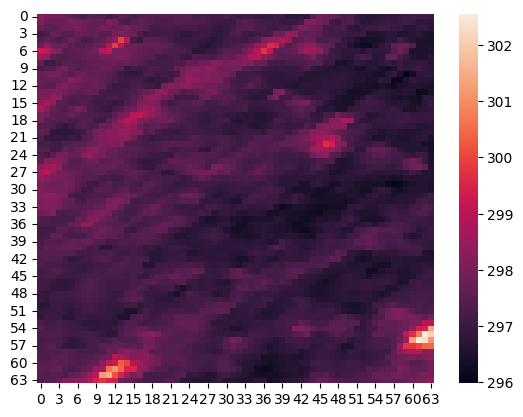

In [ ]:
import seaborn as sns
sns.heatmap(sample.detach().numpy().reshape(64, 64))

<Axes: >

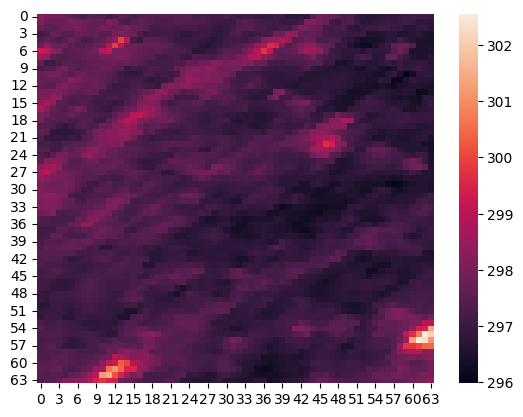

In [ ]:
sns.heatmap(img.detach().numpy().reshape(64, 64))

<Axes: >

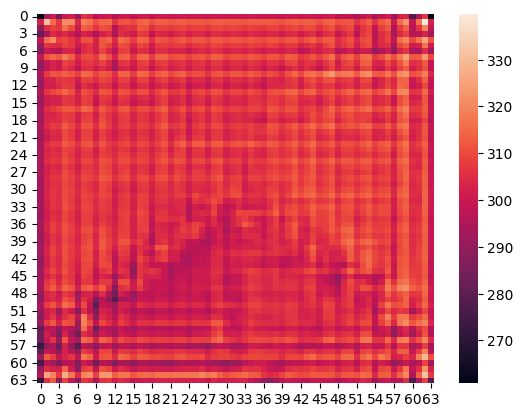

In [ ]:
sns.heatmap(pred.detach().numpy().reshape(64, 64))

In [ ]:
logs = pd.read_csv('logs/exp1/version_3/metrics.csv')

In [ ]:
logs

,epoch,step,train_loss,valid_loss
0,0,49,54.346802,NaN
1,0,99,96.950874,NaN
2,0,149,115.410217,NaN
3,0,199,58.928871,NaN
4,0,249,95.702576,NaN
...,...,...,...,...
270,24,12349,73.472260,NaN
271,24,12399,43.420235,NaN
272,24,12449,73.491760,NaN
273,24,12499,103.075294,NaN
